# Preparation

In [1]:
# Importing packages for the preparation
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv("malicious_phish.csv")
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [3]:
df = df[(df["type"] == "benign") | (df["type"] == "phishing")]
print(f'Number of benign URLs: {len(df[df["type"] == "benign"])}')
print(f'Number of phishing URLs: {len(df[df["type"] == "phishing"])}')
# There is class imbalance

Number of benign URLs: 428103
Number of phishing URLs: 94111


In [4]:
# Function to create variables for the models
def url_split(url_name):
    
    UrlLength = len(url_name)
    NumDots = url_name.count(".")
    NumDash = url_name.count("-")    
    NumAtSymbol = url_name.count("@")
    NumTildeSymbol = url_name.count("~")
    NumUnderscore = url_name.count("_")
    NumPercent = url_name.count("%")    
    NumAmpersand = url_name.count("&")
    NumHash = url_name.count("#")
    NumNumericChars = len(re.findall(r'\d', url_name))


    if url_name.startswith("http://"):
        NoHttps = 1
        url_name = url_name[7:]
    elif url_name.startswith("https://"):
        NoHttps = 0
        url_name = url_name[8:]
    else:
        NoHttps = 0

    url_parts = url_name.split("/")
    
    subdomain_count = url_parts[0].count(".")
    SubdomainLevels = subdomain_count
    
    path_component = "/".join(url_parts[1:])
    path_segments = path_component.split("/")
    PathLevel = len(path_segments)
    
    NumDashInHostname = url_parts[0].count("-")

    query_part = url_parts[-1]
    query_segments = query_part.split("?")
    query_params = query_segments[1] if len(query_segments) > 1 else ""
    NumQueryComponents = len(query_params.split("&"))

    return {
        "UrlLength": UrlLength,
        "NumDots": NumDots,
        "NumDash": NumDash,
        "NumAtSymbol": NumAtSymbol,
        "NumTildeSymbol": NumTildeSymbol,
        "NumUnderscore": NumUnderscore,
        "NumPercent": NumPercent,
        "NumAmpersand": NumAmpersand,
        "NumHash": NumHash,
        "NumNumericChars": NumNumericChars,
        "NoHttps": NoHttps,
        "PathLevel": PathLevel,
        "SubdomainLevels": SubdomainLevels,
        "NumDashInHostname": NumDashInHostname,
        "NumQueryComponents": NumQueryComponents
    }

In [5]:
df[["UrlLength", "NumDots", "NumDash", "NumAtSymbol", "NumTildeSymbol", "NumUnderscore", "NumPercent",
    "NumAmpersand", "NumHash", "NumNumericChars", "NoHttps", "PathLevel", "SubdomainLevels",
    "NumDashInHostname", "NumQueryComponents"]] = df["url"].apply(url_split).apply(pd.Series)
# The dataframe to be used:
df.head()

,url,type,UrlLength,NumDots,NumDash,NumAtSymbol,NumTildeSymbol,NumUnderscore,NumPercent,NumAmpersand,NumHash,NumNumericChars,NoHttps,PathLevel,SubdomainLevels,NumDashInHostname,NumQueryComponents
0,br-icloud.com.br,phishing,16,2,1,0,0,0,0,0,0,0,0,1,2,1,1
1,mp3raid.com/music/krizz_kaliko.html,benign,35,2,0,0,0,1,0,0,0,1,0,2,1,0,1
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,2,0,0,0,0,0,0,0,1,0,3,1,0,1
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,118,2,16,0,0,0,0,0,0,1,1,3,1,0,1
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,45,2,1,0,0,1,0,0,0,4,0,6,2,0,1


In [6]:
# Function to plot confusion matrices:
def plot_cfm(input_array):
    class_labels = ["Benign", "Phishing"]

    plt.figure(figsize=(8, 6))
    sns.heatmap(input_array, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)

    plt.xlabel("Predicted Value")
    plt.ylabel("True Value")
    plt.title("Confusion Matrix\nAccuracy: {:.2f}, Recall for Phishing: {:.2f}".format(
        (input_array[0, 0] + input_array[1, 1]) / np.sum(input_array),
        input_array[1, 1] / (input_array[1, 0] + input_array[1, 1])
    ))

    plt.show()
    return None

# Random Forest

In [7]:
# Packages needed for the random forests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score

In [8]:
# Creating the training and testing data:
X = df.drop(columns=["type", "url"])
y = df["type"]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Baseline

### Full training data

In [9]:
clf_baseline = RandomForestClassifier(n_estimators=100, random_state=42)
clf_baseline.fit(X_train, y_train)
y_pred_baseline = clf_baseline.predict(X_test)

In [10]:
accuracy = accuracy_score(y_test, y_pred_baseline)
classification_report_str = classification_report(y_test, y_pred_baseline)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_str)

Accuracy: 0.8977719904636979
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94     85611
           1       0.79      0.60      0.68     18832

    accuracy                           0.90    104443
   macro avg       0.85      0.78      0.81    104443
weighted avg       0.89      0.90      0.89    104443



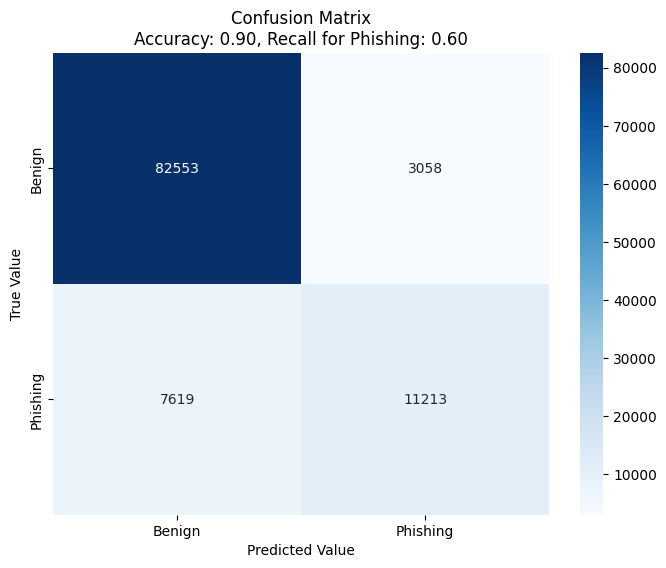

In [11]:
cfm_baseline = confusion_matrix(y_test, y_pred_baseline)
plot_cfm(cfm_baseline)

### SMOTE-data

In [12]:
# Class rebalancing using SMOTE:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [13]:
clf_smote_baseline = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

clf_smote_baseline.fit(X_train_resampled, y_train_resampled)
y_pred_smote_baseline = clf_smote_baseline.predict(X_test)

In [14]:
accuracy = accuracy_score(y_test, y_pred_smote_baseline)
classification_report_str = classification_report(y_test, y_pred_smote_baseline)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_str)

Accuracy: 0.8388786227894641
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.84      0.89     85611
           1       0.53      0.86      0.66     18832

    accuracy                           0.84    104443
   macro avg       0.75      0.85      0.78    104443
weighted avg       0.89      0.84      0.85    104443



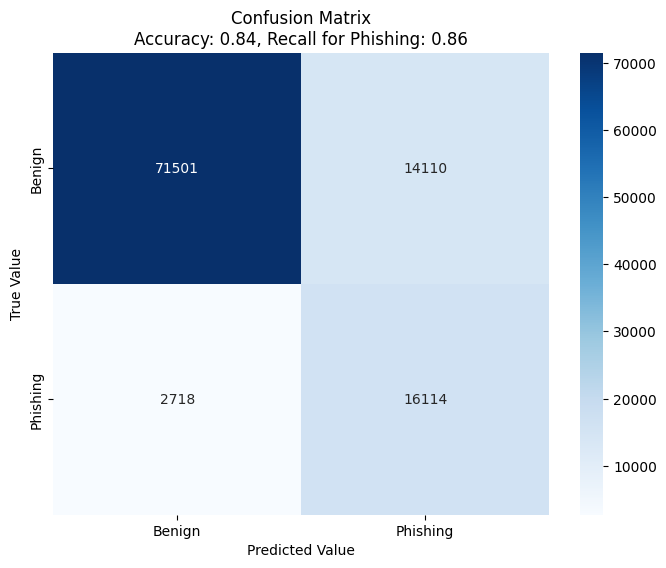

In [15]:
cfm_smote_baseline = confusion_matrix(y_test, y_pred_smote_baseline)
plot_cfm(cfm_smote_baseline)

## Hyperparameter-optimization

In [ ]:
# Our parameter grid and scoring function:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 50, 100, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
scoring = 'accuracy'

### Full training data, accuracy measured

In [ ]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           scoring=scoring,
                           cv=5,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

y_pred_best_hyper = best_model.predict(X_test)
y_best_hyper_accuracy = accuracy_score(y_test, y_pred_best_hyper)

print(f"Accuracy: {y_best_hyper_accuracy}")

cfm_hyper = confusion_matrix(y_test, y_pred_best_hyper)
plot_cfm(cfm_hyper)

### SMOTE-data, accuracy measured

In [ ]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           scoring=scoring,
                           cv=5,
                           n_jobs=-1)

grid_search.fit(X_train_resampled, y_train_resampled)

best_model_smote = grid_search.best_estimator_
best_params_smote = grid_search.best_params_

y_pred_best_hyper_smote = best_model.predict(X_test)
y_best_hyper_accuracy_smote = accuracy_score(y_test, y_pred_best_hyper_smote)

print(f"Accuracy: {y_best_hyper_accuracy_smote}")

cfm_hyper_smote = confusion_matrix(y_test, y_pred_best_hyper_smote)
plot_cfm(cfm_hyper_smote)

### Full training data, recall measured

In [ ]:
# We have to redefine the scoring function so it focuses on recall:
scoring = make_scorer(recall_score, pos_label=1)

In [ ]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           scoring=scoring,
                           cv=5,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

y_pred_best_hyper_recall = best_model.predict(X_test)
y_best_hyper_accuracy_recall = accuracy_score(y_test, y_pred_best_hyper_recall)

print(f"Accuracy: {y_best_hyper_accuracy_recall}")

cfm_hyper_recall = confusion_matrix(y_test, y_pred_best_hyper_recall)
plot_cfm(cfm_hyper_recall)

### SMOTE-data, recall measured

In [ ]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           scoring=scoring,
                           cv=5,
                           n_jobs=-1)

grid_search.fit(X_train_resampled, y_train_resampled)

best_model_smote = grid_search.best_estimator_
best_params_smote = grid_search.best_params_

y_pred_best_hyper_smote_recall = best_model.predict(X_test)
y_best_hyper_accuracy_smote_recall = accuracy_score(y_test, y_pred_best_hyper_smote_recall)

print(f"Accuracy: {y_best_hyper_accuracy_smote_recall}")

cfm_hyper_smote_recall = confusion_matrix(y_test, y_pred_best_hyper_smote_recall)
plot_cfm(cfm_hyper_smote_recall)

# Neural Networks

In [16]:
# Importing the packages for the neural networks:
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import AdamW

In [17]:
# Reworking the training and testing dataset to be able to be used by the neural networks:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Best model (full data, accuracy)

Epoch 1/10
10445/10445 [==============================] - 35s 3ms/step - loss: 0.2775 - accuracy: 0.8786 - val_loss: 0.2599 - val_accuracy: 0.8858
Epoch 2/10
10445/10445 [==============================] - 34s 3ms/step - loss: 0.2592 - accuracy: 0.8875 - val_loss: 0.2559 - val_accuracy: 0.8889
Epoch 3/10
10445/10445 [==============================] - 34s 3ms/step - loss: 0.2532 - accuracy: 0.8901 - val_loss: 0.2536 - val_accuracy: 0.8894
Epoch 4/10
10445/10445 [==============================] - 34s 3ms/step - loss: 0.2497 - accuracy: 0.8913 - val_loss: 0.2535 - val_accuracy: 0.8890
Epoch 5/10
10445/10445 [==============================] - 35s 3ms/step - loss: 0.2473 - accuracy: 0.8923 - val_loss: 0.2542 - val_accuracy: 0.8924
Epoch 6/10
10445/10445 [==============================] - 34s 3ms/step - loss: 0.2453 - accuracy: 0.8934 - val_loss: 0.2583 - val_accuracy: 0.8921
Epoch 7/10
10445/10445 [==============================] - 34s 3ms/step - loss: 0.2437 - accuracy: 0.8940 - val_loss: 0

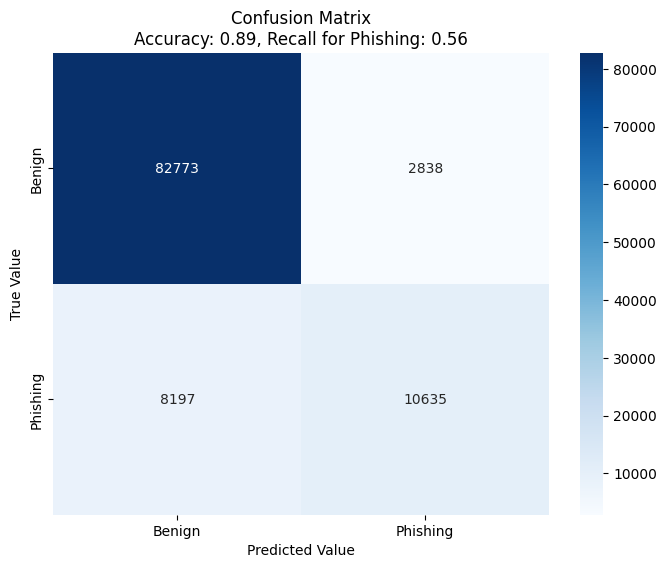

In [18]:
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(768, activation='relu'),
    layers.Dense(384, activation='relu'),
    layers.Dense(192, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

test_loss, test_accuracy = model.evaluate(X_test, y_test)

y_nn_pred = (model.predict(X_test) > 0.5).astype(int)
cfm = confusion_matrix(y_test, y_nn_pred)
plot_cfm(cfm)

## Best model (SMOTE-data, accuracy)

Epoch 1/10
17125/17125 [==============================] - 18s 1ms/step - loss: 0.4095 - accuracy: 0.8056 - val_loss: 0.5693 - val_accuracy: 0.7114
Epoch 2/10
17125/17125 [==============================] - 17s 1ms/step - loss: 0.3695 - accuracy: 0.8262 - val_loss: 0.5386 - val_accuracy: 0.7572
Epoch 3/10
17125/17125 [==============================] - 19s 1ms/step - loss: 0.3588 - accuracy: 0.8317 - val_loss: 0.4852 - val_accuracy: 0.7713
Epoch 4/10
17125/17125 [==============================] - 18s 1ms/step - loss: 0.3533 - accuracy: 0.8339 - val_loss: 0.4652 - val_accuracy: 0.7840
Epoch 5/10
17125/17125 [==============================] - 17s 974us/step - loss: 0.3495 - accuracy: 0.8357 - val_loss: 0.4618 - val_accuracy: 0.8012
Epoch 6/10
17125/17125 [==============================] - 18s 1ms/step - loss: 0.3467 - accuracy: 0.8372 - val_loss: 0.4796 - val_accuracy: 0.7914
Epoch 7/10
17125/17125 [==============================] - 18s 1ms/step - loss: 0.3442 - accuracy: 0.8380 - val_loss:

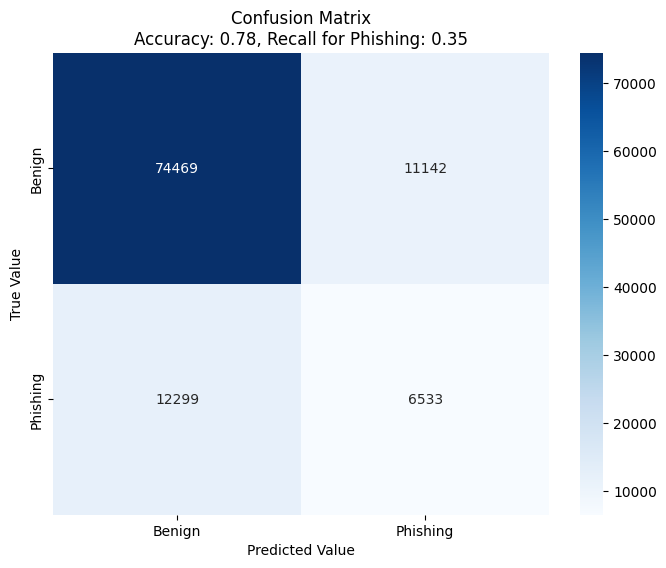

In [22]:
model_smote = keras.Sequential([
    layers.Input(shape=(X_train_resampled.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_smote.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_smote.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=32, validation_split=0.2)

test_loss_smote, test_accuracy_smote = model_smote.evaluate(X_test, y_test)

y_nn_pred = (model_smote.predict(X_test) > 0.5).astype(int)
cfsmote = confusion_matrix(y_test, y_nn_pred)
plot_cfm(cfsmote)

## Best model (full data, recall)

Epoch 1/10
10445/10445 [==============================] - 14s 1ms/step - loss: 0.2750 - accuracy: 0.8796 - val_loss: 0.2614 - val_accuracy: 0.8847
Epoch 2/10
10445/10445 [==============================] - 12s 1ms/step - loss: 0.2579 - accuracy: 0.8874 - val_loss: 0.2558 - val_accuracy: 0.8874
Epoch 3/10
10445/10445 [==============================] - 12s 1ms/step - loss: 0.2523 - accuracy: 0.8895 - val_loss: 0.2543 - val_accuracy: 0.8870
Epoch 4/10
10445/10445 [==============================] - 12s 1ms/step - loss: 0.2488 - accuracy: 0.8912 - val_loss: 0.2496 - val_accuracy: 0.8895
Epoch 5/10
10445/10445 [==============================] - 12s 1ms/step - loss: 0.2466 - accuracy: 0.8925 - val_loss: 0.2463 - val_accuracy: 0.8928
Epoch 6/10
10445/10445 [==============================] - 12s 1ms/step - loss: 0.2444 - accuracy: 0.8936 - val_loss: 0.2477 - val_accuracy: 0.8920
Epoch 7/10
10445/10445 [==============================] - 13s 1ms/step - loss: 0.2429 - accuracy: 0.8938 - val_loss: 0

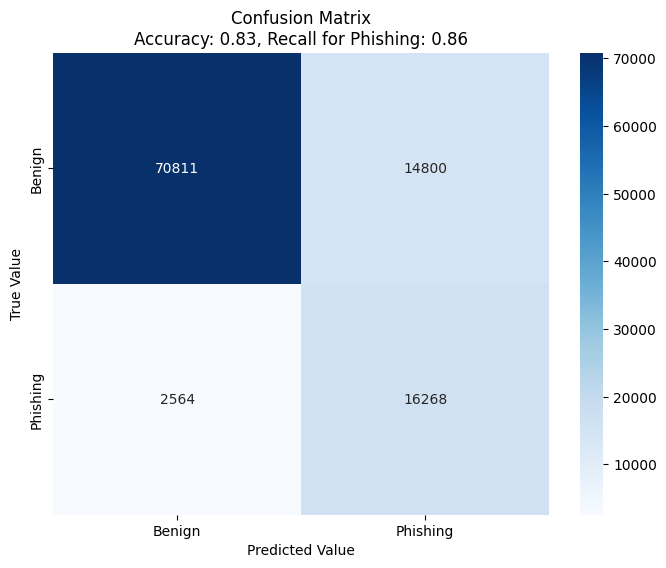

In [20]:
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(192, activation='relu'),
    layers.Dense(192, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

test_loss, test_accuracy = model.evaluate(X_test, y_test)

y_nn_pred = (model.predict(X_test) > 0.2).astype(int)
cfm = confusion_matrix(y_test, y_nn_pred)
plot_cfm(cfm)

## Best model (SMOTE-data, recall)

Epoch 1/10
17125/17125 [==============================] - 15s 849us/step - loss: 0.4485 - accuracy: 0.7881 - val_loss: 0.4246 - val_accuracy: 0.7951
Epoch 2/10
17125/17125 [==============================] - 14s 844us/step - loss: 0.4059 - accuracy: 0.8089 - val_loss: 0.5455 - val_accuracy: 0.7515
Epoch 3/10
17125/17125 [==============================] - 15s 851us/step - loss: 0.3920 - accuracy: 0.8170 - val_loss: 0.5935 - val_accuracy: 0.7295
Epoch 4/10
17125/17125 [==============================] - 14s 833us/step - loss: 0.3852 - accuracy: 0.8208 - val_loss: 0.3976 - val_accuracy: 0.8503
Epoch 5/10
17125/17125 [==============================] - 15s 852us/step - loss: 0.3806 - accuracy: 0.8231 - val_loss: 0.7216 - val_accuracy: 0.6770
Epoch 6/10
17125/17125 [==============================] - 15s 862us/step - loss: 0.3771 - accuracy: 0.8240 - val_loss: 0.4796 - val_accuracy: 0.8021
Epoch 7/10
17125/17125 [==============================] - 15s 847us/step - loss: 0.3760 - accuracy: 0.8256

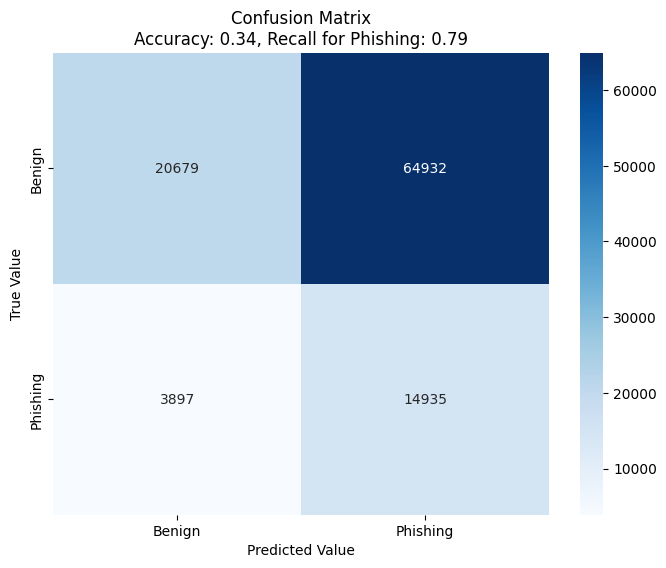

In [25]:
model_smote = keras.Sequential([
    layers.Input(shape=(X_train_resampled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_smote.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_smote.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=32, validation_split=0.2)

test_loss_smote, test_accuracy_smote = model_smote.evaluate(X_test, y_test)

y_nn_pred = (model_smote.predict(X_test) > 0.2).astype(int)
cfsmote = confusion_matrix(y_test, y_nn_pred)
plot_cfm(cfsmote)